# ENVs

**Comments**  
* Variables for directories always starts with '`dir_`' and ends without '`/`'
* Variables for dataframes always starts with '`df_`'

In [1]:
dir_pjs            = "/home/martingb/Projects"
# caid-reference
dir_main               = f"{dir_pjs}/2022/caid2-reference"
dir_data               = f"{dir_main}/data"
dir_data_sifts         = f"{dir_data}/sifts"
dir_data_alphafold     = f"{dir_data}/alphafold"
dir_data_disprot       = f"{dir_data}/disprot"
dir_src                = f"{dir_main}/src"
dir_tmp                = f"{dir_main}/tmp"
dir_results            = f"{dir_main}/results"
dir_results_tables     = f"{dir_results}/tables"
dir_results_lists      = f"{dir_results}/lists"
dir_results_references = f"{dir_results}/references"
dir_results_imgs       = f"{dir_results}/imgs"
dir_src_modules        = f"{dir_src}/modules"

# Imports

In [2]:
import os
import json
import requests
import pandas as pd
import numpy as np
from pprint import pprint

# Functions

In [3]:
def expand_region(adf: pd.DataFrame, database: str = 'disprot') -> pd.DataFrame:
    """
    """
    if database == 'disprot':
        adf["reg_position"] = list(range(int(adf["start"]), int(adf["end"]) + 1, 1))
    elif database == 'sifts':
        adf["sp_position"] = list(range(int(adf["SP_BEG"]), int(adf["SP_END"]) + 1, 1))
    else:
        raise ValueError(f"'{database}' is not a choise for parameter 'database'")
    return adf

def expand_seq(adf: pd.DataFrame) -> pd.DataFrame:
    """
    """
    adf["seq_position_aa"] = [(i+1, aa) for i, aa in enumerate(adf["sequence"])]
    return adf

def get_closed_intervals(alist : list, min_elems : int) -> list:
    """
    Describe a list of closed intervals as tuples of two ints for each
    region with at least the 'min' number of consecutive elements given.
    Example:
    alist = [2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24]
    min_elems = 10
    result: [(2,11)]
    """
    intervals = []
    interval = (int(alist[0]), int(alist[0]))
    for pos in alist[1:]:
        pos = int(pos)
        if (interval[1] + 1) == pos:
            interval = (interval[0], pos)
            continue
        else:
            if (interval[1] - interval[0]) >= min_elems - 1:
                intervals.append(interval)
            interval = (pos, pos)
            continue
    if (interval[1]) == alist[-1] and \
       (interval[1] - interval[0]) >= min_elems:
        intervals.append((interval[0], alist[-1]))
    return intervals

# CAID2

## Private DisProt json

In [4]:
try:
    os.path.exists(f"{dir_data_disprot}/entries_private_caid2.json")
except FileNotFoundError as e:
    raise e
else:
    with open(f"{dir_data_disprot}/entries_private_caid2.json", "r") as f:
        json_data = json.load(f)
        json_private = json_data['data']

## Dataframe for private DisProt entries

### Columns to take in account

In [5]:
main_columns = [ 'disprot_id'
               , 'acc'
               , 'name'
               , 'ncbi_taxon_id'           # int
               , 'organism'
               , 'sequence'
               , 'taxonomy' ]              # list of str (organisms)

region_columns = [ "disprot_namespace"  # str
                 , "region_id"          # str
                 , "date"               # str
                 , "start"              # int
                 , "end"                # int
                 , "term_id"            # str (GO and IDPO terms)
                 , "term_name"          # str (GO and IDPO description)
                 , "term_namespace"     # str (GO and IDPO namespace)
                 , "term_ontology" ]    # str (type of ontology, e.i.: GO, IDPO)

#### New columns to be used

In [6]:
region_stats_columns = [ "curator_name"       # str (Full name)
                       , "curator_orcid" ]    # str (ORCID ID of curator)

## Load dataframes

### Dataframe for ontology terms

In [8]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_ontologies_for_caid2.csv')
except FileNotFoundError as e:
    raise e
else:
    df_challenges = pd.read_csv(f'{dir_results_tables}/disprot_ontologies_for_caid2.csv', header=0)
df_challenges

,term_id,challenge
0,GO:0005488,binding
1,GO:0032029,binding
2,GO:0019979,binding
3,GO:0005519,binding
4,GO:0031859,binding
...,...,...
3082,IDPO:00061,transition
3083,IDPO:00054,transition
3084,IDPO:00057,transition
3085,IDPO:00058,transition


### Dataframe for private DisProt entries

In [9]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_private.csv')
except FileNotFoundError as e:
    raise e
else:
    df_disprot_private = pd.read_csv(f'{dir_results_tables}/disprot_private.csv', header=0)
df_disprot_private

,disprot_id,acc,name,ncbi_taxon_id,organism,sequence,taxonomy,disprot_namespace,region_id,date,start,end,term_id,term_name,term_namespace,term_ontology
0,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"['Eukaryota', 'Metazoa', 'Chordata', 'Craniata...",Structural state,DP02342r003,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO
1,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"['Eukaryota', 'Metazoa', 'Chordata', 'Craniata...",Disorder function,DP02342r006,2022-02-14T09:00:00.000Z,34,57,GO:0051179,localization,Biological process,GO
2,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"['Eukaryota', 'Metazoa', 'Chordata', 'Craniata...",Disorder function,DP02342r007,2022-02-14T09:00:00.000Z,34,57,GO:0098772,molecular function regulator,Molecular function,GO
3,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"['Eukaryota', 'Metazoa', 'Chordata', 'Craniata...",Structural state,DP02342r009,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO
4,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"['Eukaryota', 'Metazoa', 'Chordata', 'Craniata...",Disorder function,DP02342r010,2022-02-14T09:00:00.000Z,34,57,GO:0005515,protein binding,Molecular function,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,DP03744,Q9VVJ7,CG7484 protein,7227,Drosophila melanogaster,MHKCAIFLLLALSCQQIQAELTAADCRALGFIKAQLMCSSCEKLDD...,"Eukaryota, Metazoa, Ecdysozoa, Arthropoda, Hex...",Disorder function,DP03744r002,2022-06-17T10:48:39.874Z,53,178,GO:0045454,cell redox homeostasis,Biological process,GO
1164,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r001,2022-06-17T10:51:32.225Z,25,34,IDPO:00076,disorder,Structural state,IDPO
1165,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r002,2022-06-17T10:51:44.007Z,121,145,IDPO:00076,disorder,Structural state,IDPO
1166,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Disorder function,DP03745r003,2022-06-17T10:52:51.196Z,24,145,GO:0045454,cell redox homeostasis,Biological process,GO


### Dataframe for sequence

In [10]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_private_sequences.csv')
except FileNotFoundError as e:
    raise e
else:
    df_sequence = pd.read_csv(f'{dir_results_tables}/disprot_private_sequences.csv', header=0)
df_sequence

,disprot_id,acc,seq_position,seq_aa
0,DP02342,P06837,1,M
1,DP02342,P06837,2,L
2,DP02342,P06837,3,C
3,DP02342,P06837,4,C
4,DP02342,P06837,5,M
...,...,...,...,...
297441,DP03746,Q9QUH6-2,1280,Q
297442,DP03746,Q9QUH6-2,1281,L
297443,DP03746,Q9QUH6-2,1282,L
297444,DP03746,Q9QUH6-2,1283,I


### Dataframe for regions

In [11]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_private_regions.csv')
except FileNotFoundError as e:
    raise e
else:
    df_regions = pd.read_csv(f'{dir_results_tables}/disprot_private_regions.csv', header=0)
df_regions

,disprot_id,acc,challenge,reg_position
0,DP02342,P06837,disorder,1
1,DP02342,P06837,disorder,2
2,DP02342,P06837,disorder,3
3,DP02342,P06837,disorder,4
4,DP02342,P06837,disorder,5
...,...,...,...,...
57856,DP03746,Q9QUH6-2,disorder,382
57857,DP03746,Q9QUH6-2,disorder,383
57858,DP03746,Q9QUH6-2,disorder,384
57859,DP03746,Q9QUH6-2,disorder,385


### Dataframe DisProt sequences with wwPDB (SIFTS)

In [12]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_private_sifts.csv')
except FileNotFoundError as e:
    raise e
else:
    df_sequence_sifts = pd.read_csv(f'{dir_results_tables}/disprot_private_sifts.csv', header=0)
df_sequence_sifts

,disprot_id,acc,seq_position,seq_aa,sp_position
0,DP02342,P06837,1,M,NaN
1,DP02342,P06837,2,L,NaN
2,DP02342,P06837,3,C,NaN
3,DP02342,P06837,4,C,NaN
4,DP02342,P06837,5,M,NaN
...,...,...,...,...,...
297441,DP03746,Q9QUH6-2,1280,Q,NaN
297442,DP03746,Q9QUH6-2,1281,L,NaN
297443,DP03746,Q9QUH6-2,1282,L,NaN
297444,DP03746,Q9QUH6-2,1283,I,NaN


### Dataframe DisProt sequences with Alphafold score

In [13]:
try:
    os.path.exists(f'{dir_results_tables}/disprot_private_alphafold.csv')
except FileNotFoundError as e:
    raise e
else:
    df_sequence_af = pd.read_csv(f'{dir_results_tables}/disprot_private_alphafold.csv', header=0)
df_sequence_af

,disprot_id,acc,seq_position,seq_aa,lddt
0,DP02342,P06837,1,M,0.730
1,DP02342,P06837,2,L,0.734
2,DP02342,P06837,3,C,0.744
3,DP02342,P06837,4,C,0.704
4,DP02342,P06837,5,M,0.708
...,...,...,...,...,...
297441,DP03746,Q9QUH6-2,1280,Q,NaN
297442,DP03746,Q9QUH6-2,1281,L,NaN
297443,DP03746,Q9QUH6-2,1282,L,NaN
297444,DP03746,Q9QUH6-2,1283,I,NaN


## Overlaps

### Alphafold-DisProt

In [14]:
df_overlaps_merge = pd.DataFrame(columns=['disprot_id'])
for challenge in ['disorder', 'transition', 'binding']:
    df_disprot_ids_with_af_overlaps = pd.DataFrame(columns=['disprot_id'])
    # Challenge + Alphafold
    df_sequence_af_challenge = pd.merge( left     = df_sequence_af
                                       , right    = df_regions.loc[df_regions['challenge'] == challenge]
                                       , left_on  = ["disprot_id", 'acc', 'seq_position']
                                       , right_on = ["disprot_id", 'acc', 'reg_position']
                                       , how      = 'left' )
    df_sequence_af_challenge['result'] = '-'
    df_sequence_af_challenge.loc[df_sequence_af_challenge['lddt'] > 0.7, 'result'] = '0'  # Assigment: 0 for AF order
    df_sequence_af_challenge.loc[df_sequence_af_challenge['challenge'].notnull(), 'result'] = '1' # Assigment: 1 for challenge
    #df_sequence_af_challenge = df_sequence_af_challenge[(df_sequence_af_challenge['lddt'] > 0.7) & (df_sequence_af_challenge['result'] == '1')]
    #
    df_sequence_af_challenge = df_sequence_af_challenge.query('lddt > 0.7 & result == "1"')
    for disprot_id, df_overlaps in df_sequence_af_challenge.groupby(by=['disprot_id']):
        list_overlaps = get_closed_intervals(alist = df_overlaps.reg_position.tolist(), min_elems = 10)
        # if disprot_id == 'DP02342':
        #     print(f"{challenge}:\t{list_overlaps}")
        if len(list_overlaps) > 0:
            df_disprot_ids_with_af_overlaps = pd.concat( [ df_disprot_ids_with_af_overlaps
                                                         , pd.DataFrame({'disprot_id': disprot_id
                                                                       , challenge: [list_overlaps]}, columns=['disprot_id', challenge])]
                                                       , ignore_index=True)
    if not df_overlaps_merge.empty:
        df_overlaps_merge = pd.merge( left=df_overlaps_merge
                                    , right=df_disprot_ids_with_af_overlaps
                                    , left_on='disprot_id'
                                    , right_on='disprot_id'
                                    , how='outer')
    else:
        df_overlaps_merge = df_disprot_ids_with_af_overlaps.copy(deep=True)

df_overlaps_merge.to_csv(f'{dir_results_tables}/overlaps_disprot_private_af.csv', index=False)

### wwPDB-DisProt

In [15]:
df_overlaps_merge = pd.DataFrame(columns=['disprot_id'])
for challenge in ['disorder', 'transition', 'binding']:
    list_disprot_ids = []
    df_disprot_ids_with_pdb_overlaps = pd.DataFrame(columns=['disprot_id'])
    # Challenge + Alphafold
    df_sequence_sifts_challenge = pd.merge( left     = df_sequence_sifts
                                          , right    = df_regions.loc[df_regions['challenge'] == challenge]
                                          , left_on  = ["disprot_id", 'acc', 'seq_position']
                                          , right_on = ["disprot_id", 'acc', 'reg_position']
                                          , how      = 'left' )
    # df_sequence_sifts_challenge.loc[(df_sequence_sifts_challenge['sp_position']) == (df_sequence_sifts_challenge['reg_position'])]
    df_sequence_sifts_challenge = df_sequence_sifts_challenge.query('sp_position == reg_position')
    for disprot_id, df_overlaps in df_sequence_sifts_challenge.groupby(by=['disprot_id']):
        list_overlaps = get_closed_intervals(alist = df_overlaps.reg_position.tolist(), min_elems = 10)
        # if disprot_id == 'DP02342':
        #     print(f"{challenge}:\t{list_overlaps}")
        if len(list_overlaps) > 0:
            df_disprot_ids_with_pdb_overlaps = pd.concat( [ df_disprot_ids_with_pdb_overlaps
                                                         , pd.DataFrame({'disprot_id': disprot_id
                                                                       , challenge: [list_overlaps]}, columns=['disprot_id', challenge])]
                                                       , ignore_index=True)
    if not df_overlaps_merge.empty:
        df_overlaps_merge = pd.merge( left=df_overlaps_merge
                                    , right=df_disprot_ids_with_pdb_overlaps
                                    , left_on='disprot_id'
                                    , right_on='disprot_id'
                                    , how='outer')
    else:
        df_overlaps_merge = df_disprot_ids_with_pdb_overlaps.copy(deep=True)

df_overlaps_merge.to_csv(f'{dir_results_tables}/overlaps_disprot_private_pdb.csv', index=False)

## Plots

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Folder destination for plots
os.makedirs(f"{dir_results_imgs}", exist_ok=True)

### Curators

In [20]:
df_disprot_private = pd.json_normalize( data          = json_private
                                      , record_path   = ['regions']
                                      , meta          = main_columns
                                      , meta_prefix   = ''
                                      , record_prefix = '' )
df_disprot_private = df_disprot_private.loc[:, main_columns + region_columns + region_stats_columns]
df_disprot_private

,disprot_id,acc,name,ncbi_taxon_id,organism,sequence,taxonomy,disprot_namespace,region_id,date,start,end,term_id,term_name,term_namespace,term_ontology,curator_name,curator_orcid
0,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Structural state,DP02342r003,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO,Bálint Mészáros,0000-0003-0919-4449
1,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r006,2022-02-14T09:00:00.000Z,34,57,GO:0051179,localization,Biological process,GO,Federica Quaglia,0000-0002-0341-4888
2,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r007,2022-02-14T09:00:00.000Z,34,57,GO:0098772,molecular function regulator,Molecular function,GO,Federica Quaglia,0000-0002-0341-4888
3,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Structural state,DP02342r009,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO,Federica Quaglia,0000-0002-0341-4888
4,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r010,2022-02-14T09:00:00.000Z,34,57,GO:0005515,protein binding,Molecular function,GO,Bálint Mészáros,0000-0003-0919-4449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,DP03744,Q9VVJ7,CG7484 protein,7227,Drosophila melanogaster,MHKCAIFLLLALSCQQIQAELTAADCRALGFIKAQLMCSSCEKLDD...,"Eukaryota, Metazoa, Ecdysozoa, Arthropoda, Hex...",Disorder function,DP03744r002,2022-06-17T10:48:39.874Z,53,178,GO:0045454,cell redox homeostasis,Biological process,GO,Carlos Pintado Grima,0000-0002-8544-959X
1164,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r001,2022-06-17T10:51:32.225Z,25,34,IDPO:00076,disorder,Structural state,IDPO,Carlos Pintado Grima,0000-0002-8544-959X
1165,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r002,2022-06-17T10:51:44.007Z,121,145,IDPO:00076,disorder,Structural state,IDPO,Carlos Pintado Grima,0000-0002-8544-959X
1166,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Disorder function,DP03745r003,2022-06-17T10:52:51.196Z,24,145,GO:0045454,cell redox homeostasis,Biological process,GO,Carlos Pintado Grima,0000-0002-8544-959X


#### Who curated the DisProt entries for the CAID2 dataset?

In [21]:
# Comment: some regions with are not matched with IDPO and GO terms because were not considerer to be part of CAID2 challenge.
# Example:
#    IDPO:00024 (molecular recognition display site ) and its children
#    IDPO:00505 (self-regulatory activity) and its children
#    GO terms that are not child of challenge ancestors
df_disprot_private_challenges = pd.merge( left  = df_disprot_private
                                        , right = df_challenges
                                        , how   = "left"
                                        , on    = "term_id" )
df_disprot_private_challenges

,disprot_id,acc,name,ncbi_taxon_id,organism,sequence,taxonomy,disprot_namespace,region_id,date,start,end,term_id,term_name,term_namespace,term_ontology,curator_name,curator_orcid,challenge
0,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Structural state,DP02342r003,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO,Bálint Mészáros,0000-0003-0919-4449,disorder
1,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r006,2022-02-14T09:00:00.000Z,34,57,GO:0051179,localization,Biological process,GO,Federica Quaglia,0000-0002-0341-4888,NaN
2,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r007,2022-02-14T09:00:00.000Z,34,57,GO:0098772,molecular function regulator,Molecular function,GO,Federica Quaglia,0000-0002-0341-4888,NaN
3,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Structural state,DP02342r009,2022-02-14T09:00:00.000Z,1,227,IDPO:00078,pre-molten globule,Structural state,IDPO,Federica Quaglia,0000-0002-0341-4888,disorder
4,DP02342,P06837,Neuromodulin,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,"[Eukaryota, Metazoa, Chordata, Craniata, Verte...",Disorder function,DP02342r010,2022-02-14T09:00:00.000Z,34,57,GO:0005515,protein binding,Molecular function,GO,Bálint Mészáros,0000-0003-0919-4449,binding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,DP03744,Q9VVJ7,CG7484 protein,7227,Drosophila melanogaster,MHKCAIFLLLALSCQQIQAELTAADCRALGFIKAQLMCSSCEKLDD...,"Eukaryota, Metazoa, Ecdysozoa, Arthropoda, Hex...",Disorder function,DP03744r002,2022-06-17T10:48:39.874Z,53,178,GO:0045454,cell redox homeostasis,Biological process,GO,Carlos Pintado Grima,0000-0002-8544-959X,NaN
1304,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r001,2022-06-17T10:51:32.225Z,25,34,IDPO:00076,disorder,Structural state,IDPO,Carlos Pintado Grima,0000-0002-8544-959X,disorder
1305,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Structural state,DP03745r002,2022-06-17T10:51:44.007Z,121,145,IDPO:00076,disorder,Structural state,IDPO,Carlos Pintado Grima,0000-0002-8544-959X,disorder
1306,DP03745,Q8VHC3,Selenoprotein M,10090,Mus musculus,MSILLSPPSLLLLLAALVAPATSTTNYRPDWNRLRGLARGRVETCG...,"Eukaryota, Metazoa, Chordata, Craniata, Verteb...",Disorder function,DP03745r003,2022-06-17T10:52:51.196Z,24,145,GO:0045454,cell redox homeostasis,Biological process,GO,Carlos Pintado Grima,0000-0002-8544-959X,NaN


In [22]:
df_disprot_private_challenges.query('challenge.notnull()')['curator_name'].value_counts()#.sort_index()

Federica Quaglia             259
Rita Pancsa                  180
Edoardo Salladini             75
Carlos Pintado Grima          69
Lucia Chemes                  64
Jaime Santos Suárez           62
Nazanin Farahi                43
Maria Cristina Aspromonte     34
Veronika Ács                  34
Eva Schad                     31
Victoria Nugnes               28
Tamas Lazar                   23
Sandra Macedo-Ribeiro         18
Julia Marchetti               18
Luciana Rodriguez Sawicki     17
Julian Bergier                14
László Dobson                 12
Sonia Longhi                  12
Erzsébet Fichó                10
Gábor Erdős                   10
Gabriele Pozzati              10
Attila Meszaros                9
Tamás Szaniszló                8
Aditi Shenoy                   8
Mátyás Pajkos                  7
Zsófia Kálmán                  6
Bálint Mészáros                6
Claudio Bassot                 6
Javier Iserte                  5
Juliana Glavina                5
Samuel Peñ

In [23]:
df_disprot_private_challenges_core = df_disprot_private_challenges.query('challenge.notnull()').copy(deep=True)

In [24]:
s_curators = df_disprot_private_challenges_core.groupby('curator_name')['challenge'].apply(lambda x: x.value_counts())

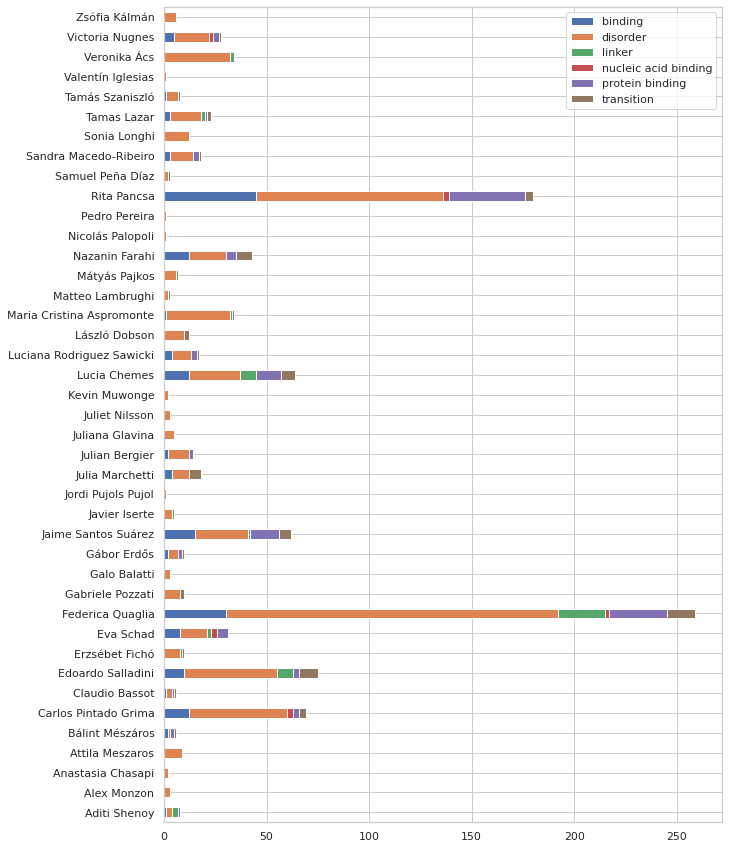

In [25]:
sns.set_theme(style="whitegrid")

fig = s_curators.unstack().plot( kind='barh'
                         , stacked=True
                         , figsize=(10,15)
                         , sort_columns=True).set(ylabel="")[0].get_figure()
fig.savefig(f"{dir_results_imgs}/barh_curators.png")

### Lenght

### Lenght with `negative` and `positive` residues